# Project work Image Processing & Computer Vision - Fruit Inspection

Francesco Farinola - francesco.farinola@studio.unibo.it



In [1]:
!git clone https://github.com/FrancescoFarinola/Fruit_Inspection.git

Cloning into 'Fruit_Inspection'...
remote: Enumerating objects: 30, done.
remote: Counting objects: 100% (30/30), done.
remote: Compressing objects: 100% (29/29), done.
remote: Total 30 (delta 1), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (30/30), done.


Imports and loading image function

In [2]:
import numpy as np
import cv2
import glob
import math
from google.colab.patches import cv2_imshow

# For second task - Kmeans
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from scipy.spatial import distance as dist
import pandas as pd

def load_images(path = 'Fruit_Inspection/data/first task/'):
  bw = {}
  color = {}
  for filename in glob.glob(path + '*.png'):
    if 'C0' in filename:
      bw[filename[-13:]] = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)
    if 'C1' in filename: 
      color[filename[-13:]] = cv2.imread(filename, cv2.IMREAD_COLOR)
  return bw, color

# First task

Task : Student should outline the image with a binary mask and search for defects

**Approach**

Preprocessing image:
1.   Compute the binary mask using the Otsu's method 
2.   Flood-fill holes inside mask
3.   Apply a bilateral filter to remove noise / blur image


For preprocessing, we only define a function to perform flood fill on binary mask

In [3]:
# Binary mask
# thres, otsu_img = cv2.threshold(v, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

def flood_fill(binary_mask):
    mask_inv = binary_mask.copy()                                   # Copy binary mask          
    h, w = binary_mask.shape[:2]                                    # Get shapes of the mask
    mask = np.zeros((h + 2, w + 2), dtype=np.uint8)                 # Create a zero mask
    cv2.floodFill(mask_inv, mask, seedPoint=(0,0), newVal=255)      # Perform flood-fill
    holes_mask = cv2.bitwise_not(mask_inv)                          # Get the inverse mask of original
    filled = binary_mask + holes_mask                               # Merge the two masks
    return filled

# Bilateral filter to remove noise
# fruit_blurred = cv2.bilateralFilter(fruit_masked, 9, 40, 50)

To detect defects, we define a function which perform the following operations:

1.   Perform the Canny edge detection algorithm to detect edges of the fruit
2.   Apply a filter on the background mask and dilate to find defects 
3.   Consolidate edges of defects by applying a closing operation (dilation followed by erosion) with an elliptic kernel

After applying the closing operation, we will obtain a mask relative to the defects inside the apple - so we simply draw elliptic circles around those detected defects.

In [4]:
def detect_defects(fruit_blurred, mask, thresh_1, thresh_2):
    # 1. Perform Canny edge detection algorithm
    canny = cv2.Canny(fruit_blurred, thresh_1, thresh_2)                            

    # 2. Dilate background and remove external contour
    background = 255 - mask                                             # Get inverse mask
    kernel = np.ones((7, 7), np.uint8)                                  # Set-up a 7x7 kernel
    background_dilated = cv2.dilate(background, kernel, iterations=3)   # Apply the kernel 3 times to dilate background
    defects_unclosed = cv2.subtract(canny, background_dilated)          # Remove external contour

    # 3. Consolidate edges with a closing operation
    structure = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (40, 40))            # Set-up an elliptic kernel 40x40
    defects = cv2.morphologyEx(defects_unclosed, cv2.MORPH_CLOSE, structure)      # MORPH_CLOSE for dilation followed by erosion

    return canny, defects

We define two further functions to draw on the colored image the contours of the fruits and ellipses on defects found based on a mask

In [5]:
def draw_defect(img, component, min_area = 10, max_area = float('inf')):
    contours, hierarchy = cv2.findContours(component, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE) #Only the contours (no hierarchy) + less points
    for c in contours:
        area = cv2.contourArea(c)
        if area > min_area and len(c) >= 5:                                                   # Small areas are filtered
            ellipse = cv2.fitEllipse(c)
            scaled_axs = (ellipse[1][0] * 2, ellipse[1][1] * 1.1)
            if scaled_axs[0] * scaled_axs[1] * math.pi < max_area:
                scaled_ellipse = ellipse[0], scaled_axs, ellipse[2]
                cv2.ellipse(img, scaled_ellipse, color = (0, 255, 255 ), thickness = 2)


def get_final_image(bw_name, color_imgs, contour_mask, defects_mask):
    ret_val, labels, stats, centroids = cv2.connectedComponentsWithStats(defects_mask, 4)     # Compute connected components of a binary image

    # Draw contours on the colored image
    bgr_img = color_imgs[bw_name.replace('C0', 'C1')].copy()                                  # Get the BGR image 
    contours, hierarchy = cv2.findContours(contour_mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)# Calculate contours of original mask - All the hierarchy and points
    cv2.drawContours(bgr_img, contours, -1, (0, 255, 0) , 1)                                  # Draw contours on the BGR image

    # Draw ellipses aroun defects
    for i in range (1, ret_val):
        defect = np.zeros_like(labels, dtype=np.uint8)                                        # Create a mask for each defect
        defect[labels == i] = 255                                                             # Change color pixels of current defect
        draw_defect(bgr_img, defect)                                                          # Draw an ellipse of the current defect

    return bgr_img


Wrap up eveything and run! :D

C0_000001.png
Original image		>>>	Threshold with Otsu's method	>>>	Masked image	 >>> 		Bilateral filter	  >>> 		Detected edges	>>>	  Defects inside structure  >>>  	Final image


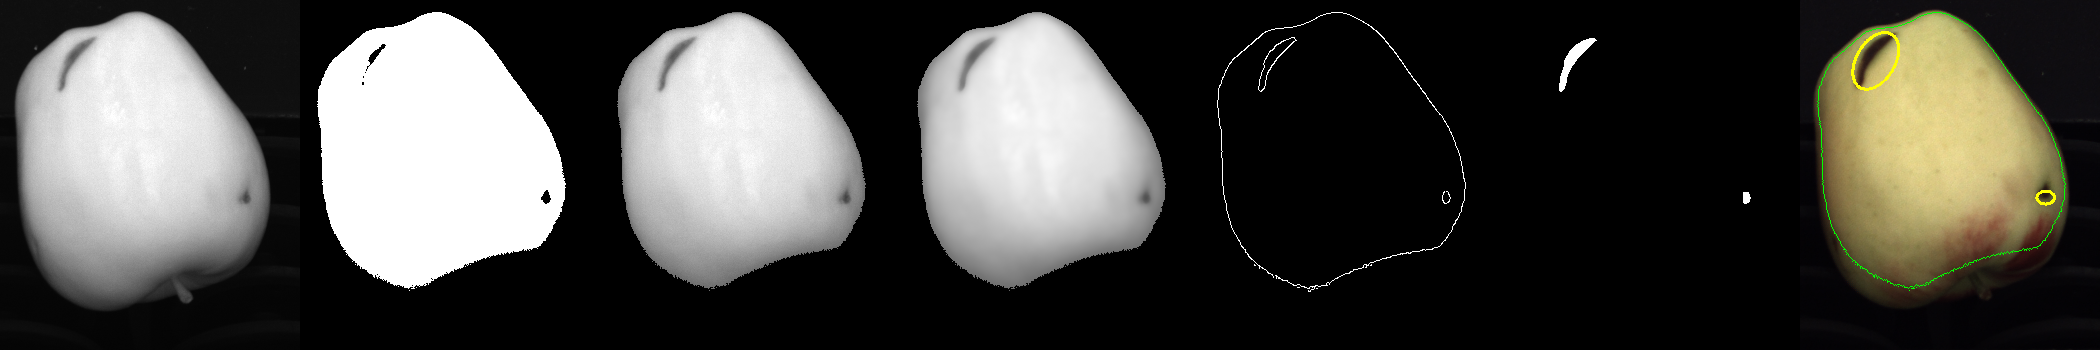

C0_000002.png
Original image		>>>	Threshold with Otsu's method	>>>	Masked image	 >>> 		Bilateral filter	  >>> 		Detected edges	>>>	  Defects inside structure  >>>  	Final image


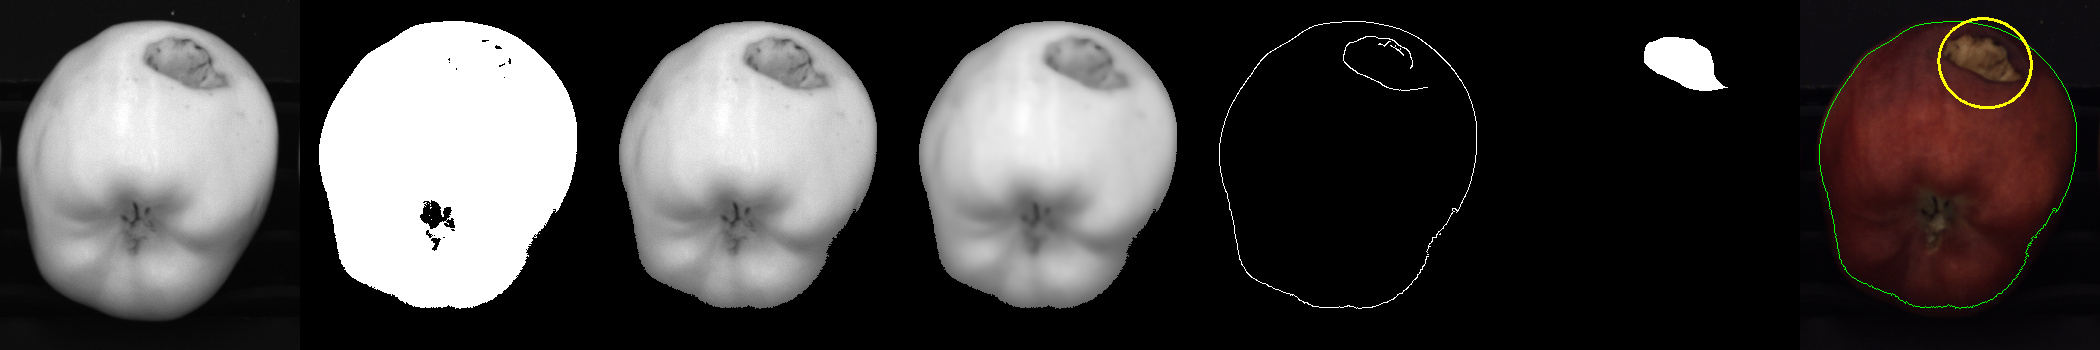

C0_000003.png
Original image		>>>	Threshold with Otsu's method	>>>	Masked image	 >>> 		Bilateral filter	  >>> 		Detected edges	>>>	  Defects inside structure  >>>  	Final image


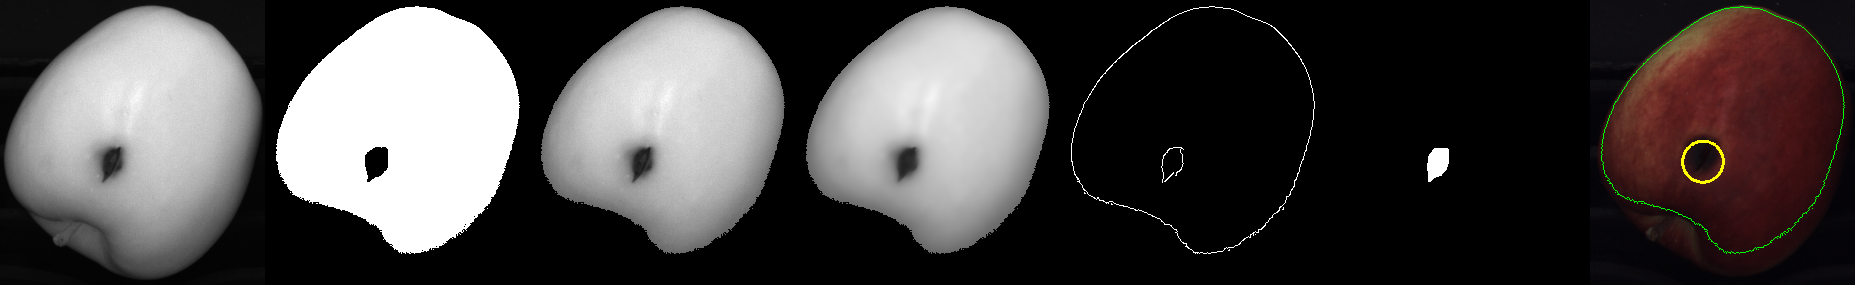

In [6]:
def run_first_task(bw_imgs, color_imgs):
    for k,v in bw_imgs.items():

        # Calculate binary mask 
        thres, otsu_img = cv2.threshold(v, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        mask = flood_fill(otsu_img)
        fruit_masked = cv2.bitwise_and(v, v, mask=mask)
        fruit_blurred = cv2.bilateralFilter(fruit_masked, 9, 40, 50)

        # Detect defects
        canny, defects = detect_defects(fruit_blurred, mask, 0, 130)
        
        #Calculate final image
        final_image = get_final_image(k, color_imgs, mask, defects)

        # Plot images at each step
        process = np.hstack((cv2.cvtColor(v, cv2.COLOR_GRAY2BGR),
                              cv2.cvtColor(otsu_img, cv2.COLOR_GRAY2BGR),
                              cv2.cvtColor(fruit_masked, cv2.COLOR_GRAY2BGR),
                              cv2.cvtColor(fruit_blurred, cv2.COLOR_GRAY2BGR),
                              cv2.cvtColor(canny, cv2.COLOR_GRAY2BGR),
                              cv2.cvtColor(defects, cv2.COLOR_GRAY2BGR),
                              final_image))
        print(k)
        print("Original image\t\t>>>\tThreshold with Otsu's method\t>>>\tMasked image\t >>> \t\tBilateral filter\t  >>> \t\tDetected edges\t>>>\t  Defects inside structure  >>>  \tFinal image")
        cv2_imshow(process)


bw_imgs_1, color_imgs_1  = load_images() 
run_first_task(bw_imgs_1, color_imgs_1)

# Second task

Task: Student should identify the russet or at least some part of it with no false positive areas

**Approach** 

We are going to clusterize the image pixels and get the mask of the cluster whose color is nearest to the one of 'russet' with some distance metric.

First thing to do is **decide which color space** to use:
 - **HSV and HLS** color spaces: These color space present some problems for the current task - its components does not follow the same scale - Hue goes from 0 to 360 and others range from 0 to 1, so when calculating the Euclidean distance in Kmeans, the Hue value dominates. Also since Hue value is acyclic, values at the edges 0-360 are identical and when using mean to calculate centroids this will result in non-sense color.
 - **RGB color space** is not a good model for color distance
 - **CIELab  and CIELuv**: Decorrelates luminance from chrominance and its value ranges may be suitable for our task - also the Delta-E distance (Euclidean distance) is good for calculating color distance in this color space.

 We are going to use CIELab color space while giving more attention to the black color - since it is not decoupled : we will apply a workaround when calculating cluster distances with pixels by hiding the black color (not consider the black cluster)

First we apply some preprocessing to the B/W image like in the first task to calculate a mask of the apple:
  - Binarize the image
  - Get the biggest component of the image
  - Fill the holes in the biggest component
  - Remove dark contour with erode

Then we get the correspondent BGR color image and apply a bilateral filter to remove some noise and apply the mask we calculated before.

In [7]:
def calculate_mask(bw):
    # Calculate binary mask
    threshold, binary_image = cv2.threshold(bw, 30, 255, cv2.THRESH_BINARY)

    # Get biggest component of the image
    retval, labels, stats, centroids = cv2.connectedComponentsWithStats(binary_image, 4)
    max_area = float("-inf")
    biggest_component = None
    for i in range(1, retval):
        component = np.zeros_like(labels, dtype=np.uint8)
        component[labels == i] = 255
        component_area = cv2.countNonZero(component)
        if component_area > max_area:
            biggest_component = component
            max_area = component_area

    # Apply flood fill from the previous task to fill the holes of the biggest component
    filled = flood_fill(biggest_component)

    # Remove dark contours of the image by applying 3 times a 5x5 filter - this time is bigger since color image may present more noise
    kernel = np.ones((5, 5), np.uint8)
    eroded = cv2.erode(filled, kernel, iterations=3)

    return binary_image, eroded


def filter_color_image(color, mask):
    # Apply a bilateral filter to remove noise but preserving edges
    blurred = cv2.bilateralFilter(color, 5, 100, 120)

    # Apply the mask
    fruit = cv2.bitwise_and(blurred, blurred, mask=mask)

    return fruit

We need to apply Kmeans to clusterize the LAB image colors.

In order to get the best clusterization possible, we perform *iterative kmeans using different number of clusters* (from 2 to 9) and get model performing best through inertia. 

Inertia is the sum of squared distance of samples to their closest cluster center. We would like this number to be as small as possible. But, if we choose K that is equal to the number of samples we will get inertia=0. 

For a trade-off we use the Elbow method and choose the best k with an inertia graph. To choose automatically this, we calculate a **scaled inertia**, which is a weighted version with a penalty. When there is no significant improvement it increases, so we choose the k with smallest scaled inertia.

In [8]:
def calculate_inertia(scaled_image, k, alpha_k=0.02):
    inertia_o = np.square((scaled_image - scaled_image.mean(axis=0))).sum()   # Inertia if we used K=1
    kmeans = KMeans(n_clusters=k, random_state=42).fit(scaled_image)          # Fit Kmeans
    scaled_inertia = kmeans.inertia_ / inertia_o + alpha_k * k                # Calculate scaled inertia
    return scaled_inertia


def get_best_k(image):
    mms = MinMaxScaler()                                                      # Instantiate MinMaxScaler to get image in range (0,1) - needed for kmeans
    img = image.reshape((image.shape[0] * image.shape[1], 3))                 # Reshape image to a 2D array
    scaled_image = mms.fit_transform(img)                                     # Scale image
    k_range = range(2,9)                                                      # Use k values from 2 to 9
    tmp = []                                                                  
    for k in k_range:
        scaled_inertia = calculate_inertia(scaled_image, k)                   # Calculate scaled inertia for k
        tmp.append((k, scaled_inertia))                                       # Append result
    results = pd.DataFrame(tmp, columns = ['k','Scaled Inertia']).set_index('k') # Store results
    best_k = results.idxmin()[0]                                              # Get minimum index
    return best_k, results

With get_dominant_colors we perform kmeans with the best k and get its centroids and labels for the image fit.

In [9]:
def get_dominant_colors(image, k):
    mms = MinMaxScaler()                                                     # Instantiate MinMaxScaler to get image in range (0,1) - needed for kmeans
    img = image.reshape((image.shape[0] * image.shape[1], 3))                # Reshape image to a 2D array
    scaled_image = mms.fit_transform(img)                                    # Scale image
    kmeans = KMeans(n_clusters=k, random_state=0).fit(scaled_image)          # Fit KMeans
    colors = mms.inverse_transform(kmeans.cluster_centers_).astype(int)      # Get color centroids as integers
    labels = kmeans.labels_.reshape(image.shape[0], image.shape[1])          # Reshape labels to image size
    return labels, colors

After getting the color centroids, we need to get the pixels which are near the russet color to identify the russet. Since the two images have different colors for russet, we need to catch a range of brown shades. 

It is not so intuitive to get brown shades like for red, green, blue or yellow (apply cv2.inRange) we have to do some workarounds:
  - Get two samples for brown:  light and dark brown
  - Calculate distances from each centroid w.r.t. the two above
  - Ignore the cluster relative to the black color - as it would assign dark brown to it
  - Get as russet index the one with minimum Manhattan distance w.r.t. light and dark brown.

In [10]:
def centroids_distance(centroids, brown):
    distances = []
    for c in centroids[1:]:               # For each centroid except black centroid (always first)
        d = dist.cityblock(c, brown)      # Calculate Manhattan distance between centroid and ref brown
        distances.append(d)               
    return distances


def min_distance_index1(dist_1, dist_2):
    min_1 = min(dist_1)                   # Get min of first distance list
    idx_1 = dist_1.index(min_1)           # Get index of min in first list
    min_2 = min(dist_2)                   # Get min of second distance list
    idx_2 = dist_2.index(min_2)           # Get index of min in second list
    if min_1 < min_2:                     # Return the correct index
        return idx_1 + 1                  # +1 because we ignored the black cluster - so we are 1 behind
    else:
        return idx_2 + 1


def get_russet_index(centroids):
    russets = np.array([[[139, 111, 63],  # RGB of light brown
                         [59, 42, 23]]],  # RGB of dark brown
                       dtype=np.uint8)
    browns = cv2.cvtColor(russets, cv2.COLOR_RGB2LAB)[0]  # Convert to LAB values
    dist_1 = centroids_distance(centroids, browns[0])     # Calculate distances with light brown
    dist_2 = centroids_distance(centroids, browns[1])     # Calculate distances with dark brown
    return min_distance_index1(dist_1, dist_2)            # Return the minimum index

Wrap up everything and run :D

C0_000005.png
Original image >>>		Masked image >>>		Russet mask >>>		Final image


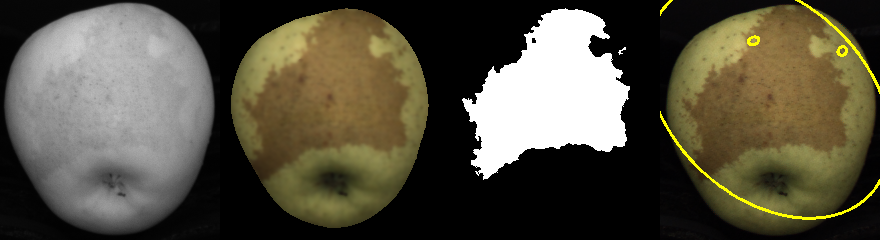

C0_000004.png
Original image >>>		Masked image >>>		Russet mask >>>		Final image


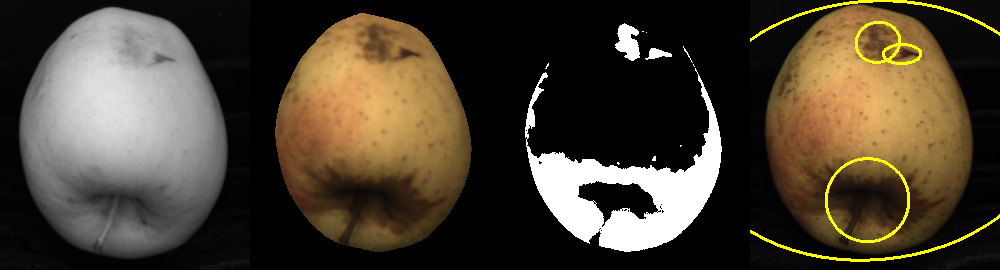

In [11]:
def run_second_task(bw_imgs, color_imgs):
    for k,v in bw_imgs.items():
        binary_image, mask = calculate_mask(v)
        color_image = color_imgs_2[k.replace('C0', 'C1')].copy()        # Get the RGB image
        fruit = filter_color_image(color_image, mask)                   # Apply filter to RGB image
        fruit_lab = cv2.cvtColor(fruit, cv2.COLOR_BGR2LAB)              # Convert to LAB color space
        best_k, results = get_best_k(fruit_lab)                         # Calculate best k for KMeans
        labels, colors = get_dominant_colors(fruit_lab, best_k)         # Get pixels clusterized and color centroids
        russet_index = get_russet_index(colors)                         # Get the russet index relative to color centroids

        # Get russet mask
        russet_component = np.zeros_like(labels, dtype=np.uint8)
        russet_component[labels == russet_index] = 255

        # Draw defects
        retval, labels, stats, centroids = cv2.connectedComponentsWithStats(russet_component, 4)
        for i in range (1, retval):
            component = np.zeros_like(labels, dtype=np.uint8)
            component[labels == i] = 255
            draw_defect(color_image, component, max_area = 500000)

        # Plot images at each step
        process = np.hstack((cv2.cvtColor(v, cv2.COLOR_GRAY2BGR),
                             fruit, 
                             cv2.cvtColor(russet_component, cv2.COLOR_GRAY2BGR), 
                             color_image))
        print(k)
        print("Original image >>>\t\tMasked image >>>\t\tRusset mask >>>\t\tFinal image")
        cv2_imshow(process)

bw_imgs_2, color_imgs_2 = load_images('Fruit_Inspection/data/second task/')
run_second_task(bw_imgs_2, color_imgs_2)

# Final Challenge

Task : detect defects on kiwi with special care on background noise on conveyor belt and sticker

The approach is exactly the same as in the first task but we have to make some more operatiosn when calculating the binary mask of the kiwi.

To calculate the mask of the kiwi only - without background noise we:
  - Calculate a binary mask with basic threshold method with lower bound = 40 (higher than before)
  - Flood-fill holes inside the mask
  - In the current mask we have noise in background (sticker/dirt), so we erode the borders to prevent that the kiwi mask is near another object. e.g. like this we separate the kiwi from the sticker.
  - Get the component in the binary mask with maximum area using *cv2.connectedComponentsWithStats*

In [12]:
def calculate_mask_biggest_component(bw):
    ret, thresh = cv2.threshold(bw ,40,255,cv2.THRESH_BINARY)
    mask = flood_fill(thresh)
    fruit_masked = cv2.bitwise_and(bw, bw, mask=mask)

    #Erode borders - this helps also separating the kiwi from near objects in the background, e.g. sticker
    # a 7x7 one time is enough
    kernel = np.ones((7, 7), np.uint8)
    eroded = cv2.erode(fruit_masked, kernel, iterations=1)

    #Get component with maximum area
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(eroded , 4 , cv2.CV_32S)                 # Get connected components with stats like AREA
    max_label, max_size = max([(i, stats[i, cv2.CC_STAT_AREA]) for i in range(1, num_labels)], key=lambda x: x[1])   # Iterate over components and get the one with max area
    max_component = np.zeros_like(labels, dtype=np.uint8)                                                            # Init max_component
    max_component[labels == max_label] = 255                                                                         # Change values of index found

    return thresh, mask, max_component

C0_000006.png
Original image  >>>		 Initial mask  >>>	Max component mask  >>>	    Bilateral filter  >>>	   Canny edges  >>>	   Defects detected  >>>		 Final image


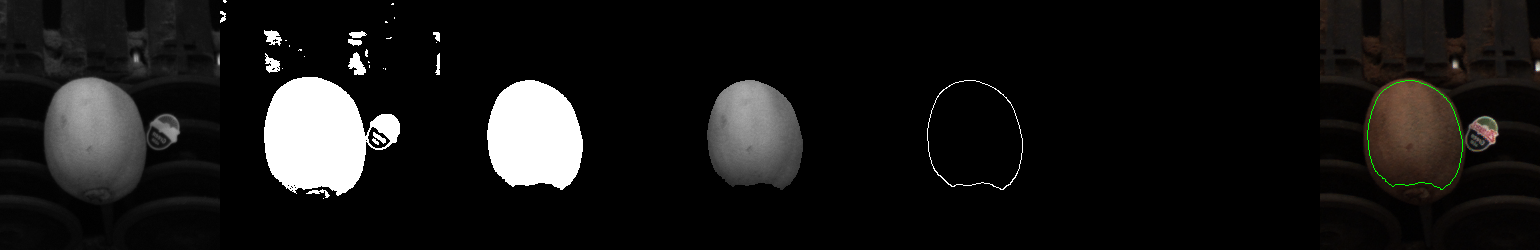

C0_000009.png
Original image  >>>		 Initial mask  >>>	Max component mask  >>>	    Bilateral filter  >>>	   Canny edges  >>>	   Defects detected  >>>		 Final image


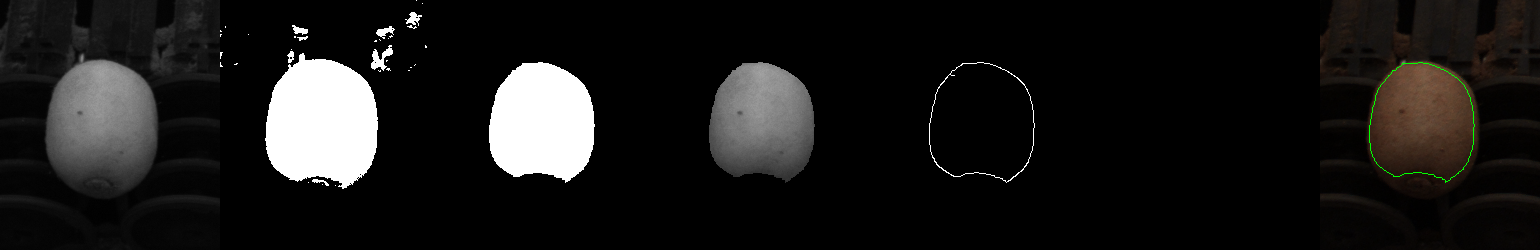

C0_000010.png
Original image  >>>		 Initial mask  >>>	Max component mask  >>>	    Bilateral filter  >>>	   Canny edges  >>>	   Defects detected  >>>		 Final image


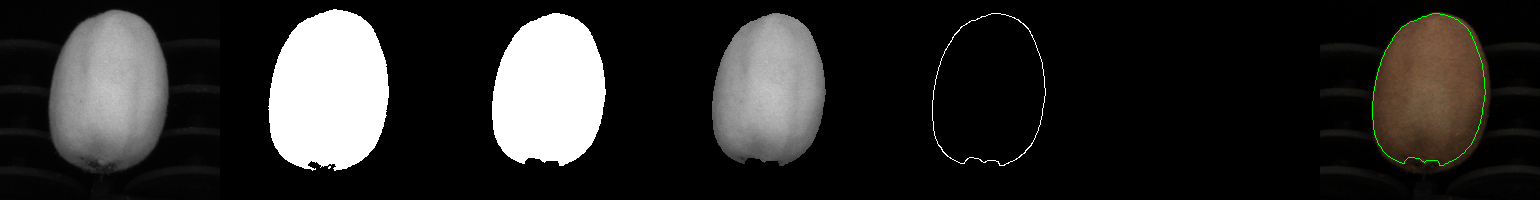

C0_000007.png
Original image  >>>		 Initial mask  >>>	Max component mask  >>>	    Bilateral filter  >>>	   Canny edges  >>>	   Defects detected  >>>		 Final image


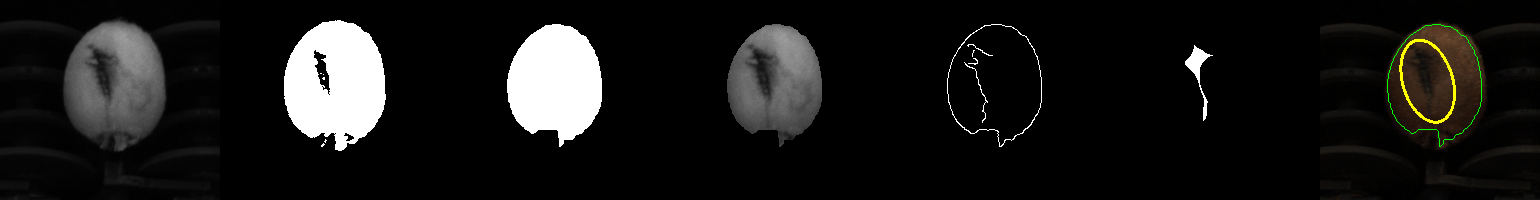

C0_000008.png
Original image  >>>		 Initial mask  >>>	Max component mask  >>>	    Bilateral filter  >>>	   Canny edges  >>>	   Defects detected  >>>		 Final image


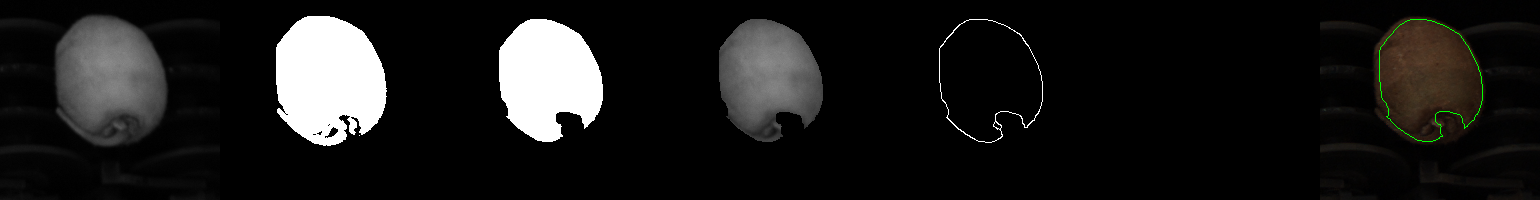

In [13]:
def run_final_challenge(bw_imgs, color_imgs):
    for k,v in bw_imgs.items():
      thresh, mask, max_component = calculate_mask_biggest_component(v)               # Calculate mask of biggest component - kiwi
      fruit = cv2.bitwise_and(v, v, mask=max_component)                               # Apply mask 
      fruit_blurred = cv2.bilateralFilter(fruit, 7, 40, 50)                           # Blur image with bilateral filter to remove noise
      canny, defects = detect_defects(fruit_blurred, mask, 10, 110)                   # Like in first task but we change threshold of Canny detector
      final_image = get_final_image(k, color_imgs, max_component, defects)            # Draw contours and ellipses on found defects

      #Stack images of the process and show them
      process = np.hstack((cv2.cvtColor(v, cv2.COLOR_GRAY2BGR),
                           cv2.cvtColor(thresh, cv2.COLOR_GRAY2BGR),
                           cv2.cvtColor(max_component, cv2.COLOR_GRAY2BGR),
                           cv2.cvtColor(fruit, cv2.COLOR_GRAY2BGR),
                           cv2.cvtColor(canny, cv2.COLOR_GRAY2BGR),
                           cv2.cvtColor(defects, cv2.COLOR_GRAY2BGR), final_image))
      print(k)
      print("Original image  >>>\t\t Initial mask  >>>\tMax component mask  >>>\t    Bilateral filter  >>>\t   Canny edges  >>>\t   Defects detected  >>>\t\t Final image")
      cv2_imshow(process)


bw_imgs_3, color_imgs_3 = load_images('Fruit_Inspection/data/final challenge/')
run_final_challenge(bw_imgs_3, color_imgs_3)